# Contour Maps

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapped
from mapped.density import GeoKernelDensity
mapped.__version__

'19.12.1'

Import some random example point data.

In [2]:
from mapped.example_data import mad_points
points = mad_points()
points.head()

,number,letter,geometry
0,52.064541,B,POINT (-9937504.907 5319115.429)
1,50.761888,A,POINT (-9954448.395 5315974.064)
2,55.079217,B,POINT (-9943478.867 5307611.290)
3,52.615496,A,POINT (-9936556.658 5318097.390)
5,51.080653,B,POINT (-9938781.955 5309253.875)


The class `GeoKernelDensity` wraps the more generic scikit-learn `KernelDensity`, providing some 
simplifying default options and features.

In [3]:
from mapped.density import GeoKernelDensity
gkde = GeoKernelDensity(bandwidth=0.00015).fit(points)

One handy feature is the ability to directly output contour plots.

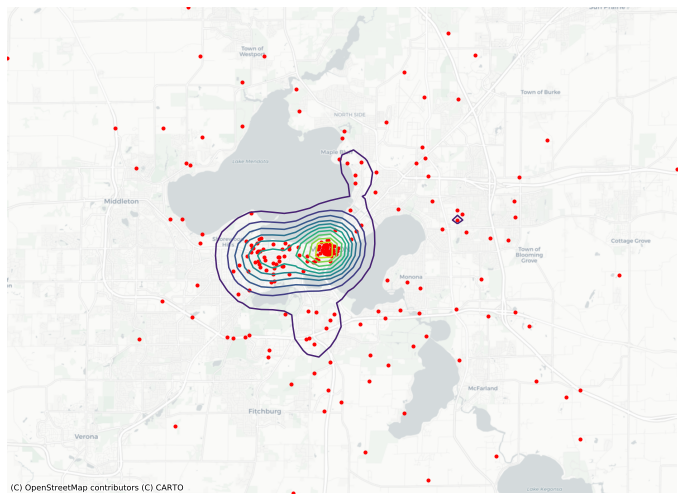

In [4]:
ax = gkde.contour(basemap='CartoDB', figsize=(12,12), levels=10)
points.plot(color='red', marker='.', ax=ax );

The `multifit` fits seperate kernel densities on segments of the data defined by `groupby`.

In [5]:
gkde_m = GeoKernelDensity(bandwidth=0.00015).multifit(points, 'letter')

For example, the demo points contain two classes of point, 'A' and 'B'.

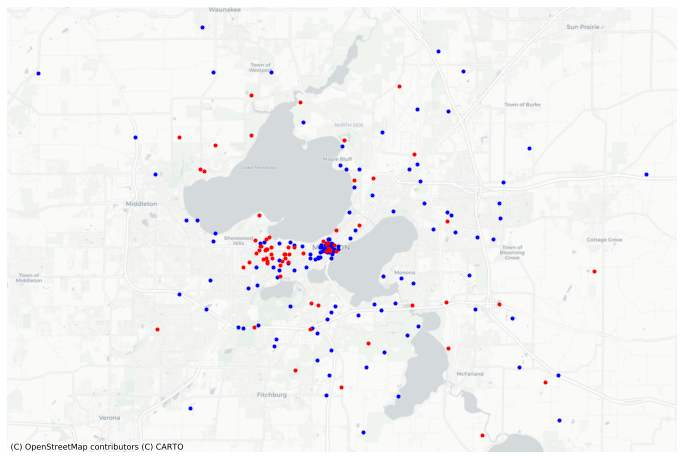

In [6]:
ax = points.query("letter=='A'").plot(color='blue', marker='.', basemap='CartoDB', figsize=(12,12))
points.query("letter=='B'").plot(color='red', marker='.', ax=ax );

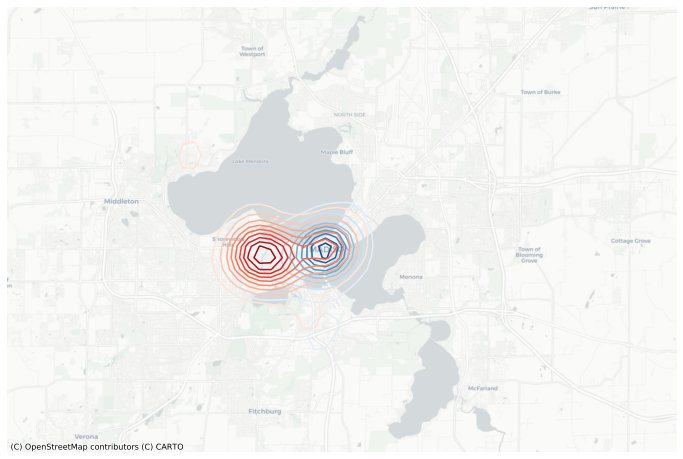

In [7]:
ax = gkde_m['A'].contour(basemap='CartoDB', figsize=(12,12), levels=10, cmap='Blues');
gkde_m['B'].contour(ax=ax, figsize=(12,12), levels=10, cmap='Reds');

The red and blue contours on the plot above have different scales.  To 
harmonize the scales, we need to compute the levels explicitly and pass 
them to the function.  We can also smooth it out my increasing the resolution
from the  default (which is 100).

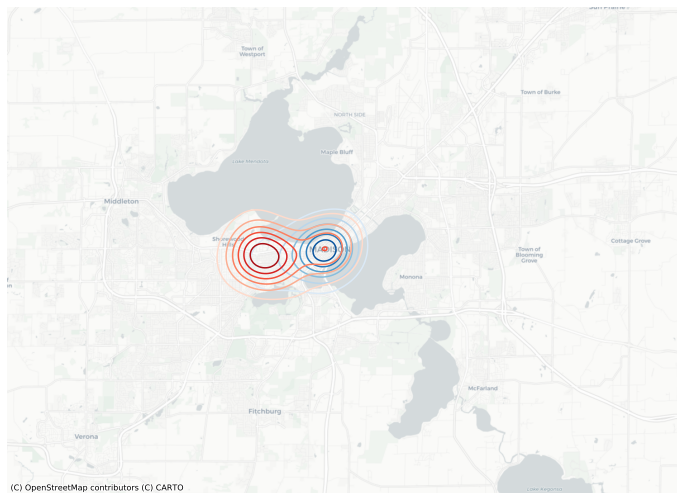

In [8]:
mesh = gkde_m.meshgrid(resolution=300, bounds=points, total='TOT')
levels = np.linspace(0, max(mesh['A'].max(), mesh['B'].max()), 8)

ax = mesh.contour('A', basemap='CartoDB', figsize=(12,12), levels=levels, cmap='Blues');
mesh.contour('B', ax=ax, figsize=(12,12), levels=levels, cmap='Reds');

We can mask out lakes if we have a the shape of the lakes.  We can use OSMnx
to get those shapes from OpenStreetMaps.

In [9]:
import osmnx as ox
lakes = ox.gdf_from_places([
    'Lake Mendota, Dane County, WI',
    'Lake Monona, Dane County, WI',
    'Lake Wingra, Dane County, WI',
    'Second Lake, Dane County, WI',
    'Lower Mud Lake, Dane County, WI',
    'Lake Kegonsa, Dane County, WI',
])
lakes = lakes.append(
    ox.gdf_from_place('Yahara River, Dane County, WI', which_result=5),
)

lakes = lakes.to_crs(mesh.crs)

In [10]:
mask = np.ones(len(mesh), dtype=bool)
for lake in lakes.geometry:
    mask &= ~mesh.within(lake)

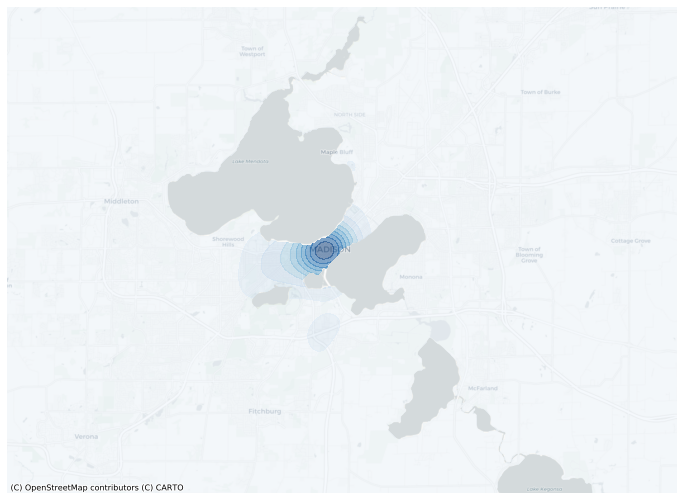

In [11]:
mesh.contour(
    'A', 
    filled=True, 
    alpha=0.5,
    cmap='Blues', 
    basemap='CartoDB', 
    levels=10, 
    figsize=(12,12),
    mask=mask,
);

Plot the relative kernel density of A.

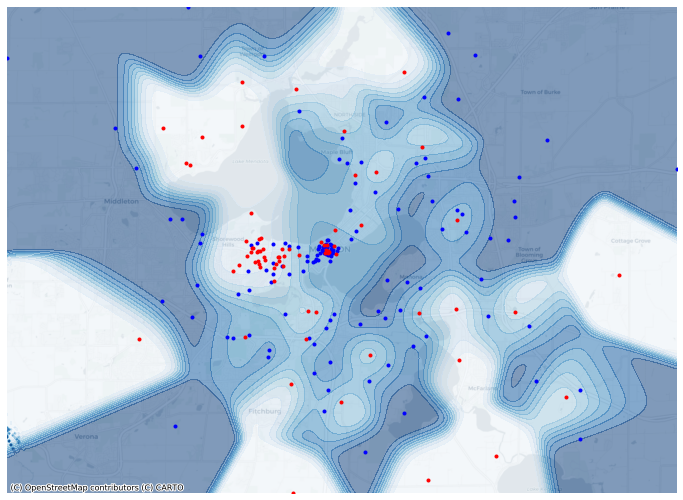

In [12]:
ax = mesh.contour(
    'A/TOT', 
    filled=True, 
    alpha=0.5,
    cmap='Blues', 
    basemap='CartoDB', 
    levels=10, 
    figsize=(12,12),
)

# Also plot the source points by color.
ax = points.query("letter=='A'").plot(ax=ax, color='blue', marker='.')
ax = points.query("letter=='B'").plot(ax=ax, color='red', marker='.');

Plot the relative kernel density of B, masking lakes.

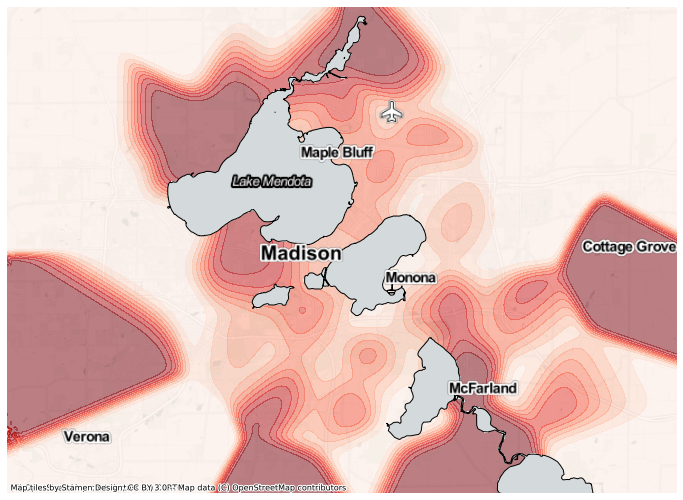

In [13]:
ax = mesh.contour(
    'B/TOT', 
    filled=True, 
    alpha=0.5,
    cmap='Reds', 
    basemap='CartoDB.PositronNoLabels', 
    levels=10, 
    mask=mask,
    figsize=(12,12),
)

# Draw a black border over lakeshores for a cleaner look.
lakes.plot(color="none", edgecolor="black", ax=ax)
mapped.add_basemap(ax=ax, tiles='Stamen.TonerLabels', zoom=11);
